In [5]:
import numpy as np
import matplotlib.pyplot as plt

def sech(x: np.ndarray) -> np.ndarray:
    """Hyperbolic secant."""
    return 1.0 / np.cosh(x)



kappa_over_2pi = 5.8e6   
chi_over_2pi   = 5.4e6   
Tm             = 240e-9  


def nbar_to_s(nbar: float,
              eta: float,
              kappa_over_2pi: float = kappa_over_2pi,
              chi_over_2pi: float = chi_over_2pi,
              Tm: float = Tm) -> float:
    
    kappa = 2.0 * np.pi * kappa_over_2pi
    chi   = 2.0 * np.pi * chi_over_2pi
    theta = 2.0 * np.arctan(chi / kappa)
    sin_theta_over_2 = np.sin(theta / 2.0)
    return np.sqrt(2.0 * nbar * eta * kappa * Tm * sin_theta_over_2)


def backaction_bloch(I: np.ndarray,
                     Q: np.ndarray,
                     s: float,
                     eta: float = 1.0,
                     T1: float = np.inf,
                     T2: float = np.inf,
                     tau: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    aI = s * I
    aQ = s * Q

    Z = np.tanh(aI)
    sech_aI = sech(aI)
    X = sech_aI * np.sin(aQ)
    Y = sech_aI * np.cos(aQ)


    if eta < 1.0:
       
        factor_eta = np.exp(- (s ** 2) * (1.0 / eta - 1.0))
        X *= factor_eta
        Y *= factor_eta


    if np.isfinite(T1) and T1 > 0.0:
        Z *= np.exp(-tau / T1)
    if np.isfinite(T2) and T2 > 0.0:
        deph_factor = np.exp(-tau / T2)
        X *= deph_factor
        Y *= deph_factor

    return X, Y, Z


def simulate_experiment_for_strength(s: float,
                                     n_shots: int = 30_000,
                                     eta: float = 1.0,
                                     T1: float = np.inf,
                                     T2: float = np.inf,
                                     tau: float = 0.0,
                                     random_seed: int | None = None
                                     ) -> tuple[np.ndarray, np.ndarray,
                                                np.ndarray, np.ndarray, np.ndarray]:
    
    rng = np.random.default_rng(random_seed)


    I = rng.normal(loc=0.0, scale=1.0, size=n_shots)
    Q = rng.normal(loc=0.0, scale=1.0, size=n_shots)

    X, Y, Z = backaction_bloch(I, Q, s, eta=eta, T1=T1, T2=T2, tau=tau)

    return I, Q, X, Y, Z



def build_conditional_maps(I: np.ndarray,
                           Q: np.ndarray,
                           X: np.ndarray,
                           Y: np.ndarray,
                           Z: np.ndarray,
                           n_bins: int = 201,
                           extent: float = 6.0
                           ) -> tuple[np.ndarray, np.ndarray, np.ndarray,
                                      np.ndarray, np.ndarray]:
    
    edges = np.linspace(-extent, extent, n_bins + 1)


    I_idx = np.digitize(I, edges) - 1  
    Q_idx = np.digitize(Q, edges) - 1


    counts = np.zeros((n_bins, n_bins), dtype=int)
    sum_X = np.zeros_like(counts, dtype=float)
    sum_Y = np.zeros_like(counts, dtype=float)
    sum_Z = np.zeros_like(counts, dtype=float)


    valid = (
        (I_idx >= 0) & (I_idx < n_bins) &
        (Q_idx >= 0) & (Q_idx < n_bins)
    )


    np.add.at(counts, (I_idx[valid], Q_idx[valid]), 1)
    np.add.at(sum_X, (I_idx[valid], Q_idx[valid]), X[valid])
    np.add.at(sum_Y, (I_idx[valid], Q_idx[valid]), Y[valid])
    np.add.at(sum_Z, (I_idx[valid], Q_idx[valid]), Z[valid])


    Xc = np.full_like(sum_X, np.nan, dtype=float)
    Yc = np.full_like(sum_Y, np.nan, dtype=float)
    Zc = np.full_like(sum_Z, np.nan, dtype=float)

    mask = counts > 0
    Xc[mask] = sum_X[mask] / counts[mask]
    Yc[mask] = sum_Y[mask] / counts[mask]
    Zc[mask] = sum_Z[mask] / counts[mask]

    return edges, Xc, Yc, Zc, counts



def estimate_slopes(I: np.ndarray,
                    Q: np.ndarray,
                    X: np.ndarray,
                    Y: np.ndarray,
                    Z: np.ndarray,
                    window: float = 0.5
                    ) -> tuple[float, float]:
    
    mask = (np.abs(I) < window) & (np.abs(Q) < window)
    I0 = I[mask]
    Q0 = Q[mask]
    Z0 = Z[mask]
    X0 = X[mask]


    A_I = np.vstack([I0, np.ones_like(I0)]).T
    coeff_Z, *_ = np.linalg.lstsq(A_I, Z0, rcond=None)
    slope_ZI = coeff_Z[0]


    A_Q = np.vstack([Q0, np.ones_like(Q0)]).T
    coeff_X, *_ = np.linalg.lstsq(A_Q, X0, rcond=None)
    slope_XQ = coeff_X[0]

    return slope_ZI, slope_XQ



def fit_slope_vs_s(s_values: np.ndarray,
                   slopes: np.ndarray
                   ) -> tuple[float, float]:
   
    A = np.vstack([s_values, np.ones_like(s_values)]).T
    m, b = np.linalg.lstsq(A, slopes, rcond=None)[0]
    return m, b


def fit_eta_from_Y(s_values: np.ndarray,
                   Y_means: np.ndarray,
                   tau: float,
                   T2: float
                   ) -> tuple[float, float]:
   
    mask = Y_means > 0.0
    s2 = s_values[mask] ** 2
    y  = -np.log(Y_means[mask])

    A = np.vstack([s2, np.ones_like(s2)]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]

    eta_fit = 1.0 / a
    return eta_fit, b



def plot_conditional_maps(nbar: float,
                          s: float,
                          edges: np.ndarray,
                          Xc: np.ndarray,
                          Yc: np.ndarray,
                          Zc: np.ndarray,
                          counts: np.ndarray
                          ) -> None:

    extent = [edges[0], edges[-1], edges[0], edges[-1]]

    fig, axes = plt.subplots(1, 4, figsize=(14, 3.5))
    fig.suptitle(f"Conditional maps for n̄ = {nbar:.3g}, s = {s:.2f}")

    im0 = axes[0].imshow(
        np.log10(counts.T + 1),
        origin='lower',
        extent=extent,
        aspect='equal',
        cmap='viridis'
    )
    axes[0].set_title("log10 counts")
    axes[0].set_xlabel("I/σ")
    axes[0].set_ylabel("Q/σ")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)


    im1 = axes[1].imshow(
        Xc.T,
        origin='lower',
        extent=extent,
        aspect='equal',
        vmin=-1.0,
        vmax=1.0,
        cmap='RdBu_r'
    )
    axes[1].set_title("<X>_c")
    axes[1].set_xlabel("I/σ")
    axes[1].set_ylabel("Q/σ")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)


    im2 = axes[2].imshow(
        Yc.T,
        origin='lower',
        extent=extent,
        aspect='equal',
        vmin=-1.0,
        vmax=1.0,
        cmap='RdBu_r'
    )
    axes[2].set_title("<Y>_c")
    axes[2].set_xlabel("I/σ")
    axes[2].set_ylabel("Q/σ")
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    im3 = axes[3].imshow(
        Zc.T,
        origin='lower',
        extent=extent,
        aspect='equal',
        vmin=-1.0,
        vmax=1.0,
        cmap='RdBu_r'
    )
    axes[3].set_title("<Z>_c")
    axes[3].set_xlabel("I/σ")
    axes[3].set_ylabel("Q/σ")
    fig.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

    fig.tight_layout(rect=[0, 0.0, 1, 0.92])



Simulating n̄ = 0.01, s = 0.154 (1 / 9), n_shots = 30000
Simulating n̄ = 0.02, s = 0.218 (2 / 9), n_shots = 30000
Simulating n̄ = 0.05, s = 0.345 (3 / 9), n_shots = 30000
Simulating n̄ = 0.1, s = 0.488 (4 / 9), n_shots = 30000
Simulating n̄ = 0.2, s = 0.690 (5 / 9), n_shots = 30000
Simulating n̄ = 0.5, s = 1.092 (6 / 9), n_shots = 30000
Simulating n̄ = 1, s = 1.544 (7 / 9), n_shots = 30000
Simulating n̄ = 2, s = 2.184 (8 / 9), n_shots = 30000
Simulating n̄ = 5, s = 3.452 (9 / 9), n_shots = 30000

=== Slope fits (small-s hypothesis) ===
Fitted m_Z   ≈ e^(-τ/T1): 0.663
Fitted m_X   ≈ e^(-τ/T2): -0.045
Input  T1    = 2.80 µs,  Fitted T1 ≈ 0.92 µs
Input  T2    = 1.00 µs,  Fitted T2 ≈ inf µs

=== Efficiency fit from <Y>(s) ===
Input  η_true   = 0.200
Fitted η_fit    ≈ 0.221
Fitted offset b ≈ 0.565 (should be ≈ τ/T2 = 0.380)

Saved results to "backaction_sim_results.npz".


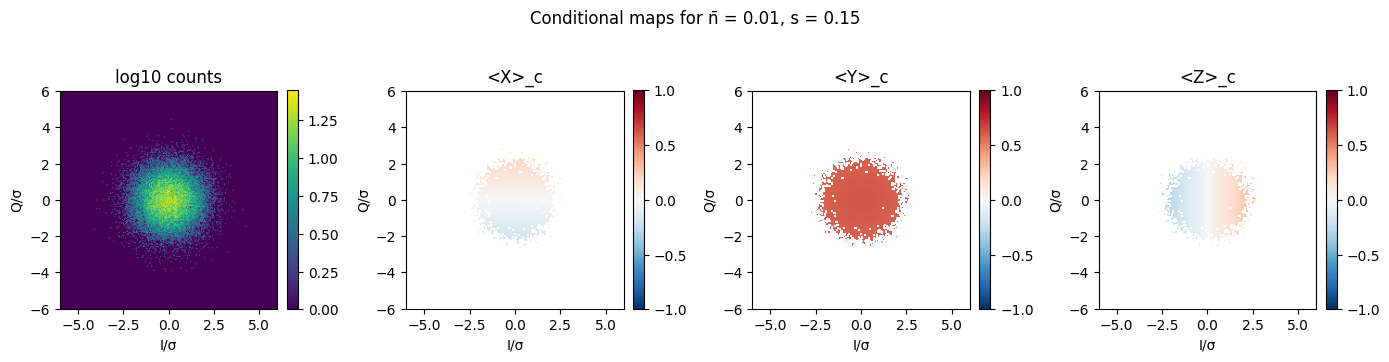

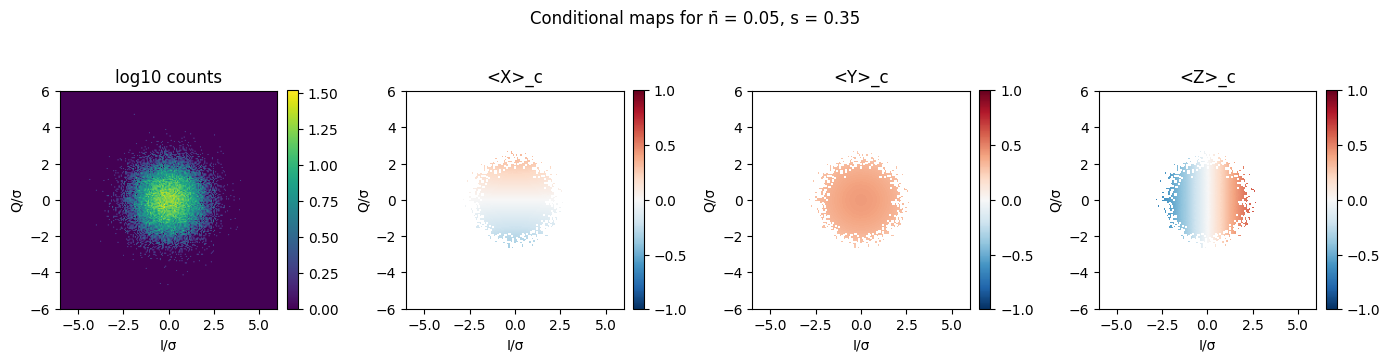

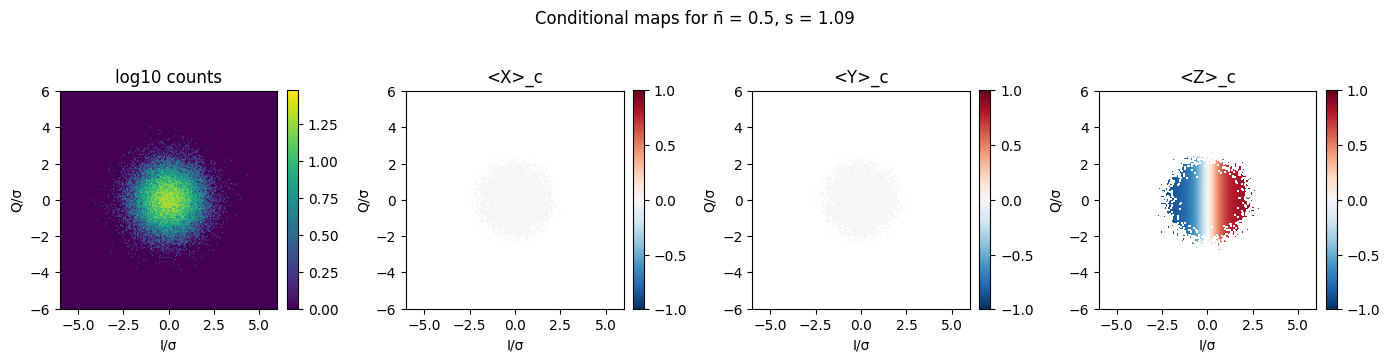

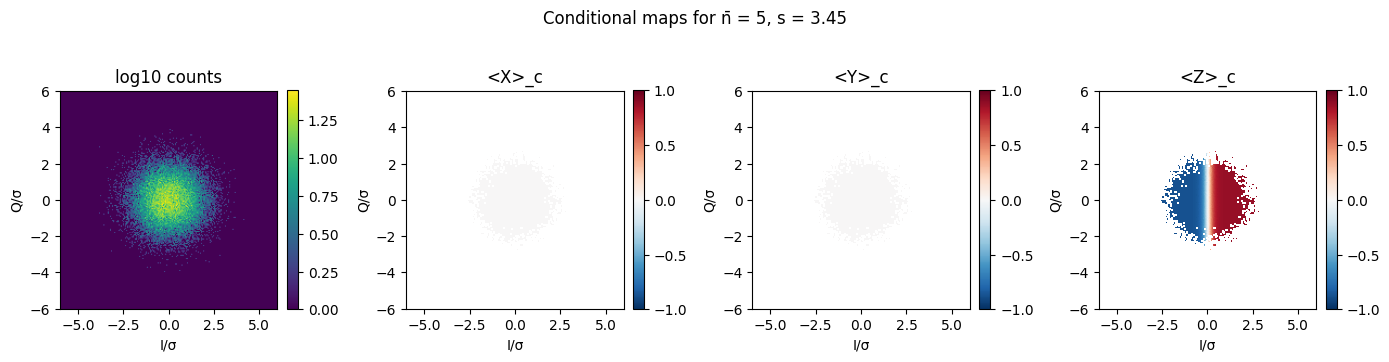

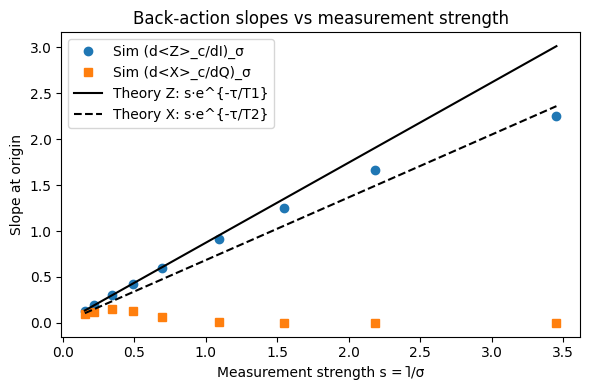

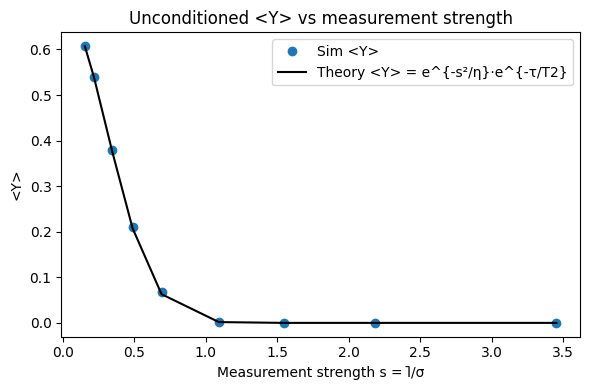

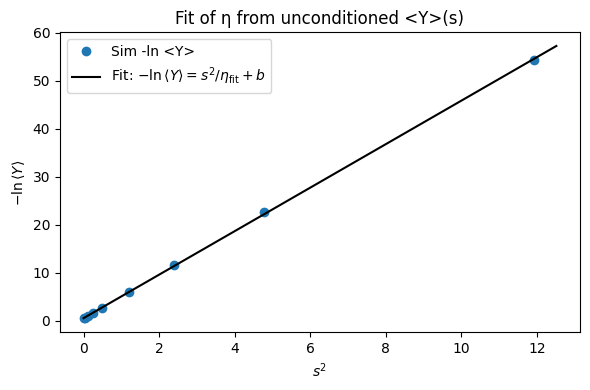

In [6]:
T1 = 2.8e-6        
T2 = 1.0e-6        
tau = 3.8e-7       
eta_true = 0.2     

nbar_values = np.array([0.01, 0.02, 0.05, 0.1,
                        0.2, 0.5, 1.0, 2.0, 5.0])


s_values = np.array([nbar_to_s(nb, eta_true) for nb in nbar_values])


n_shots = 30_000

slopes_ZI = []
slopes_XQ = []
Y_means = []


indices_for_maps = [0, 2, 5, 8]  


for idx, (nb, s) in enumerate(zip(nbar_values, s_values)):
    print(f"Simulating n̄ = {nb:.3g}, s = {s:.3f} "
        f"({idx+1} / {len(nbar_values)}), n_shots = {n_shots}")

    I, Q, X, Y, Z = simulate_experiment_for_strength(
        s,
        n_shots=n_shots,
        eta=eta_true,
        T1=T1,
        T2=T2,
        tau=tau,
        random_seed=1234 + idx
    )


    slope_ZI, slope_XQ = estimate_slopes(I, Q, X, Y, Z, window=0.4)
    slopes_ZI.append(slope_ZI)
    slopes_XQ.append(slope_XQ)


    Y_means.append(np.mean(Y))

    if idx in indices_for_maps:
        edges, Xc, Yc, Zc, counts = build_conditional_maps(
            I, Q, X, Y, Z,
            n_bins=201,
            extent=6.0
        )
        plot_conditional_maps(nb, s, edges, Xc, Yc, Zc, counts)

slopes_ZI = np.array(slopes_ZI)
slopes_XQ = np.array(slopes_XQ)
Y_means = np.array(Y_means)


slope_ZI_theory = s_values * np.exp(-tau / T1)
slope_XQ_theory = s_values * np.exp(-tau / T2)


Y_theory = np.exp(- (s_values ** 2) / eta_true) * np.exp(-tau / T2)


m_Z, b_Z = fit_slope_vs_s(s_values, slopes_ZI)
m_X, b_X = fit_slope_vs_s(s_values, slopes_XQ)


T1_fit = -tau / np.log(m_Z) if m_Z > 0 else np.inf
T2_fit = -tau / np.log(m_X) if m_X > 0 else np.inf

print("\n=== Slope fits (small-s hypothesis) ===")
print(f"Fitted m_Z   ≈ e^(-τ/T1): {m_Z:.3f}")
print(f"Fitted m_X   ≈ e^(-τ/T2): {m_X:.3f}")
print(f"Input  T1    = {T1*1e6:.2f} µs,  Fitted T1 ≈ {T1_fit*1e6:.2f} µs")
print(f"Input  T2    = {T2*1e6:.2f} µs,  Fitted T2 ≈ {T2_fit*1e6:.2f} µs")


eta_fit, offset_fit = fit_eta_from_Y(s_values, Y_means, tau, T2)
print("\n=== Efficiency fit from <Y>(s) ===")
print(f"Input  η_true   = {eta_true:.3f}")
print(f"Fitted η_fit    ≈ {eta_fit:.3f}")
print(f"Fitted offset b ≈ {offset_fit:.3f} (should be ≈ τ/T2 = {tau/T2:.3f})")


plt.figure(figsize=(6, 4))
plt.plot(s_values, slopes_ZI, 'o', label='Sim (d<Z>_c/dI)_σ')
plt.plot(s_values, slopes_XQ, 's', label='Sim (d<X>_c/dQ)_σ')
plt.plot(s_values, slope_ZI_theory, 'k-', label='Theory Z: s·e^{-τ/T1}')
plt.plot(s_values, slope_XQ_theory, 'k--', label='Theory X: s·e^{-τ/T2}')
plt.xlabel("Measurement strength s = Ī/σ")
plt.ylabel("Slope at origin")
plt.legend()
plt.title("Back-action slopes vs measurement strength")
plt.tight_layout()


plt.figure(figsize=(6, 4))
plt.plot(s_values, Y_means, 'o', label='Sim <Y>')
plt.plot(s_values, Y_theory, 'k-', label='Theory <Y> = e^{-s²/η}·e^{-τ/T2}')
plt.xlabel("Measurement strength s = Ī/σ")
plt.ylabel("<Y>")
plt.title("Unconditioned <Y> vs measurement strength")
plt.legend()
plt.tight_layout()


plt.figure(figsize=(6, 4))
plt.plot(s_values**2, -np.log(Y_means), 'o', label='Sim -ln <Y>')
s2_line = np.linspace(0, s_values[-1]**2 * 1.05, 100)
plt.plot(s2_line,
        (1.0/eta_fit)*s2_line + offset_fit,
        'k-',
        label=r'Fit: $- \ln \langle Y \rangle = s^2/\eta_{\rm fit} + b$')
plt.xlabel(r"$s^2$")
plt.ylabel(r"$-\ln \langle Y \rangle$")
plt.title("Fit of η from unconditioned <Y>(s)")
plt.legend()
plt.tight_layout()


np.savez(
    "backaction_sim_results.npz",
    nbar=nbar_values,
    s=s_values,
    slopes_ZI=slopes_ZI,
    slopes_XQ=slopes_XQ,
    slopes_ZI_theory=slope_ZI_theory,
    slopes_XQ_theory=slope_XQ_theory,
    Y_means=Y_means,
    Y_theory=Y_theory,
    T1_input=T1,
    T2_input=T2,
    tau=tau,
    eta_true=eta_true,
    T1_fit=T1_fit,
    T2_fit=T2_fit,
    eta_fit=eta_fit,
    eta_offset_fit=offset_fit,
)
print('\nSaved results to "backaction_sim_results.npz".')

plt.show()
